In [1]:
from importing_sb import *
from pitch_plotting import *
import numpy as np
import pandas as pd

data_dir = '/Users/jm533/Documents/GitHub/football_analytics/open-data/data/'

comp_data = open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]
#event_data = [[open_data(data_dir + 'events/{}.json'.format(j['match_id'])) for j in i] for i in match_data]
#match_data = [pd.DataFrame(open_data(data_dir + 'matches/11/{}.json'.format(i))).sort_values('match_week',ascending=True) for i in la_liga_seasons]
#event_data = [[pd.DataFrame(open_data(data_dir + 'events/{}.json'.format(j))) for j in i['match_id']] for i in match_data]


comp_df = pd.DataFrame(comp_data)
#match_df = pd.DataFrame(match_data)

In [2]:
years = list(range(2015,2003,-1))
match_id = {}
for i in range(len(years)):
    df = pd.DataFrame(match_data[i])
    match_id[str(years[i])] = df['match_id'].values

In [3]:
event_data = {}
for year in years:
    event_data[str(year)] = []
    for match in match_id[str(year)]:
        event_data[str(year)].append(open_data(data_dir + 'events/{}.json'.format(str(match))))

In [4]:
event_data_15 = [i for match in event_data['2015'] for i in match]

In [5]:
messi = 'Lionel Andrés Messi Cuccittini'

In [6]:
# Calculate amount of 90s played per season
m_90_played = []
for year in years:
    tot = 0
    for i in range(len(event_data[str(year)])):
        tot += get_player_info(event_data[str(year)][i],messi).sec_played
        
    m_90_played.append((tot / 60) / 90)

In [13]:
m_90_played

[31.193703703703704,
 38.763888888888886,
 28.72759259259259,
 30.458333333333332,
 37.52240740740741,
 32.82055555555556,
 32.55166666666667,
 28.943333333333335,
 22.907777777777774,
 22.799074074074074,
 10.357037037037037,
 1.0203703703703704]

## Shots

In [6]:
shots = {}
for year in years:
    shots[str(year)] = [get_shots(match) for match in event_data[str(year)]]

In [7]:
shots_seas = {}
for year in shots:
    shots_seas[str(year)] = pd.concat(shots[str(year)])
    shots_seas[str(year)].reset_index(inplace=True)

In [8]:
m_shots_seas = {}
for year in years:
    m_shots_seas[str(year)] = shots_seas[str(year)][shots_seas[str(year)]['player'] == messi]

In [30]:
m_h = np.array([len(m_shots_seas[str(i)][m_shots_seas[str(i)]['body_part'] == 'Head']) for i in years])
m_h_g = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Head')&(m_shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
m_lf = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Left Foot')]) for i in years])
m_lf_g = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Left Foot')&(m_shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
m_rf = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Right Foot')]) for i in years])
m_rf_g = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Right Foot')&(m_shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])

h = np.array([len(shots_seas[str(i)][shots_seas[str(i)]['body_part'] == 'Head']) for i in years])
h_g = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Head')&(shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
lf = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Left Foot')]) for i in years])
lf_g = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Left Foot')&(shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
rf = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Right Foot')]) for i in years])
rf_g = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Right Foot')&(shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])

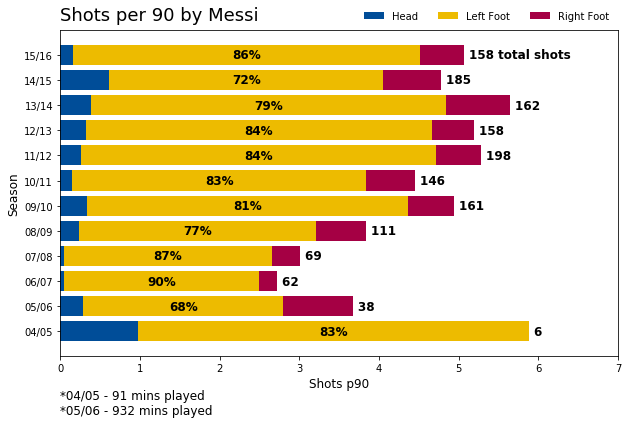

In [112]:
ind = list(reversed(np.arange(len(years))))
seasons = ['15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06','04/05']

fig, ax = plt.subplots(figsize=(10,6))
p1 = ax.barh(ind, m_h / m_90_played,color='#004d98')
p2 = ax.barh(ind, m_lf / m_90_played,left=m_h / m_90_played,color='#edbb00')
p3 = ax.barh(ind, m_rf / m_90_played,left=(m_lf+m_h) / m_90_played,color='#a50044')

#labels = ax.get_xticklabels()
ax.set_yticks(ind)
ax.set_yticklabels(seasons)
ax.set_xlabel('Shots p90',fontsize=12)
ax.set_ylabel('Season',fontsize=12)
ax.set_xlim(0,7)
#ax.set_title('Shots per 90 by Messi')

ax.text(0.0,1.03,'Shots per 90 by Messi',transform=ax.transAxes,fontsize=18)
ax.legend((p1[0], p2[0], p3[0]), ('Head', 'Left Foot', 'Right Foot'),ncol=3,loc=4,bbox_to_anchor=(1.0,1.0),frameon=False)

tshotslabels = ['total shots']
for i in range(len(seasons)-1):
    tshotslabels.append('')

for i in range(len(ind)):
    ax.annotate('{0} {1}'.format((m_h + m_lf + m_rf)[i],tshotslabels[i]),
                    xy=(((m_h + m_lf + m_rf)[i] / m_90_played[i]), ind[i]), xytext=(5,0),
                    textcoords="offset points",
                    ha='left', va='center', fontsize=12, fontweight='bold')
    
ax.text(0.0, -0.1, '*04/05 - 91 mins played\n*05/06 - 932 mins played', ha='left', va='top', transform=ax.transAxes, fontsize=12)

for i in range(len(ind)):
    ax.annotate('{:.0f}%'.format((m_lf[i]/sum([m_h[i],m_lf[i],m_rf[i]])) * 100),
                    xy=(((m_lf[i] / 2) + m_h[i]) / m_90_played[i], ind[i]), xytext=(0,0),
                    textcoords="offset points",
                    ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()
#fig.savefig('example_plots/messi_shotsp90.pdf',bbox_inches='tight')

/Users/jm533/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


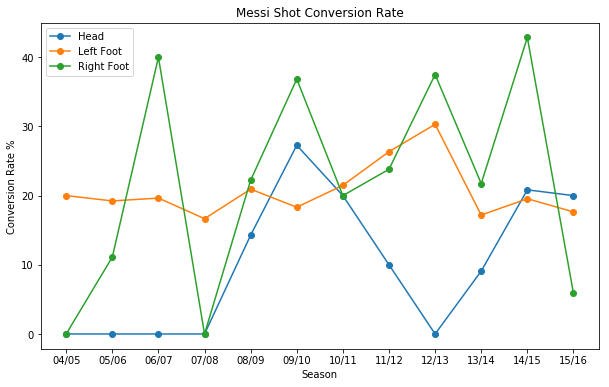

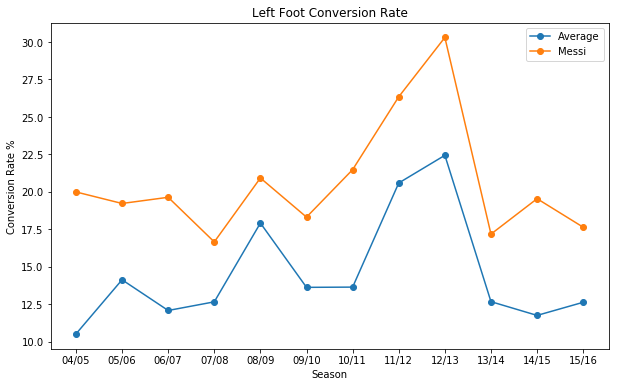

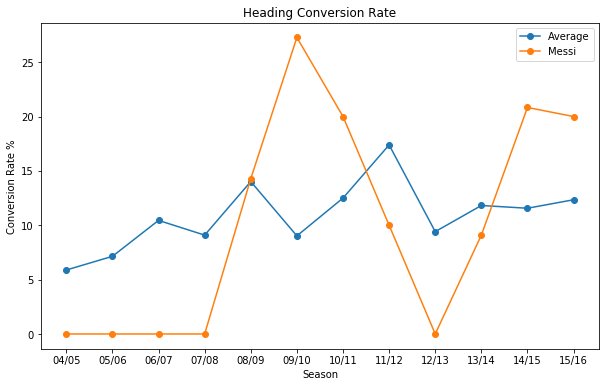

In [111]:
seasons = ['15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06','04/05']
ind = list(reversed(np.arange(len(seasons))))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, (np.array(m_h_g) / np.array(m_h)) * 100, '-o',label='Head')
ax.plot(ind, (np.array(m_lf_g) / np.array(m_lf)) * 100, '-o',label='Left Foot')
ax.plot(ind, np.nan_to_num((np.array(m_rf_g) / np.array(m_rf))) * 100, '-o',label='Right Foot')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Conversion Rate %',title='Messi Shot Conversion Rate')
ax.legend(loc='best')

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, (np.array(lf_g) / np.array(lf)) * 100, '-o',label='Average')
ax.plot(ind, (np.array(m_lf_g) / np.array(m_lf)) * 100, '-o',label='Messi')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Conversion Rate %',title='Left Foot Conversion Rate')
ax.legend(loc='best')

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, (np.array(h_g) / np.array(h)) * 100, '-o',label='Average')
ax.plot(ind, (np.array(m_h_g) / np.array(m_h)) * 100, '-o',label='Messi')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Conversion Rate %',title='Heading Conversion Rate')
ax.legend(loc='best')

plt.show()

In [26]:
print(np.mean((np.array(h_g) / np.array(h)) * 100))
print(np.mean((np.array(m_h_g) / np.array(m_h)) * 100))

10.886390340275925
10.123556998557


## Passes

In [113]:
passes = {}
for year in years:
    passes[str(year)] = [get_pass(match) for match in event_data[str(year)]]

In [114]:
passes_seas = {}
for year in passes:
    passes_seas[str(year)] = pd.concat(passes[str(year)])
    passes_seas[str(year)].reset_index(inplace=True)

In [115]:
m_pass_seas = {}
m_pass_op_seas ={}
for year in years:
    m_pass_seas[str(year)] = passes_seas[str(year)][passes_seas[str(year)]['player'] == messi]
    m_pass_op_seas[str(year)] = passes_seas[str(year)][(passes_seas[str(year)]['player'] == messi)&
                                                       (passes_seas[str(year)]['pass_type'] == 'Standard')]

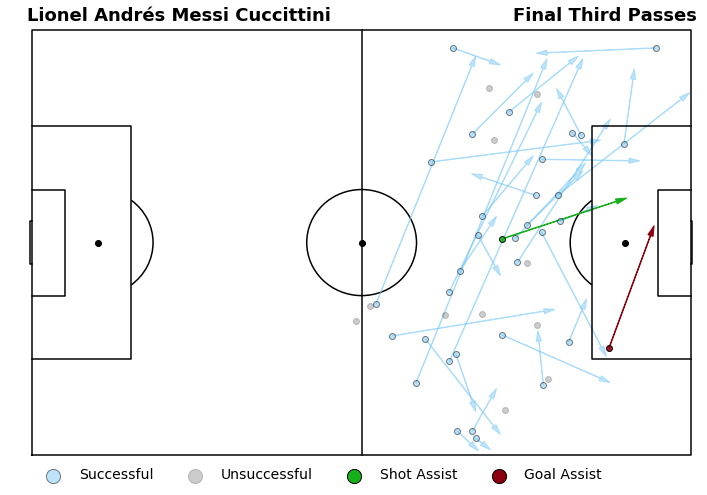

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22bc8be80>)

In [116]:
pass_map_player(event_data['2015'][3],messi,'third')

### Pass Quantity

In [117]:
m_pass_op_tot = [len(m_pass_op_seas[str(i)]) for i in years]
m_ft_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['end_x'] >= 80.]) for i in years]
m_box_pass_op_tot = [len(m_pass_op_seas[str(i)][(m_pass_op_seas[str(i)]['end_x'] >= 102.)&
                                                (m_pass_op_seas[str(i)]['end_y'] >= 18.)&
                                                (m_pass_op_seas[str(i)]['end_y'] <= 62.)]) for i in years]

In [118]:
m_pass_p90 = np.array(m_pass_op_tot) / np.array(m_90_played)
m_ft_pass_p90 = np.array(m_ft_pass_op_tot) / np.array(m_90_played)
m_box_pass_p90 = np.array(m_box_pass_op_tot) / np.array(m_90_played)

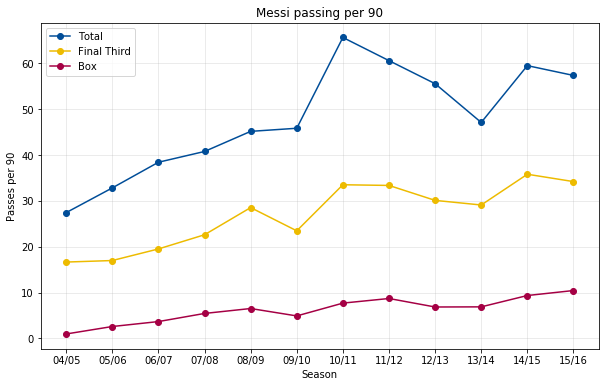

In [219]:
ind = np.flip(np.arange(len(years)))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,m_pass_p90,'-o',c='#004d98',label='Total')
ax.plot(ind,m_ft_pass_p90,'-o',c='#edbb00',label='Final Third')
ax.plot(ind,m_box_pass_p90,'-o',c='#a50044',label='Box')

ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Passes per 90',title='Messi passing per 90')
ax.legend(loc=2)

ax.grid(True,alpha=0.3)

plt.show()

### What about types of passes?

In [120]:
m_thru_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['technique'] == 'Through Ball']) for i in years]
m_cross_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['cross'] == True]) for i in years]
m_switch_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['switch'] == True]) for i in years]

In [121]:
m_thru_p90 = np.array(m_thru_pass_op_tot) / np.array(m_90_played)
m_cross_p90 = np.array(m_cross_pass_op_tot) / np.array(m_90_played)
m_switch_p90 = np.array(m_switch_pass_op_tot) / np.array(m_90_played)

In [122]:
man_dates = [0,3+(5/12),7+(6/12),8+(7/12),9+(5/12)]
man_names = ['Rijkaard','Guardiola','Vilanova','Martino','Enrique']

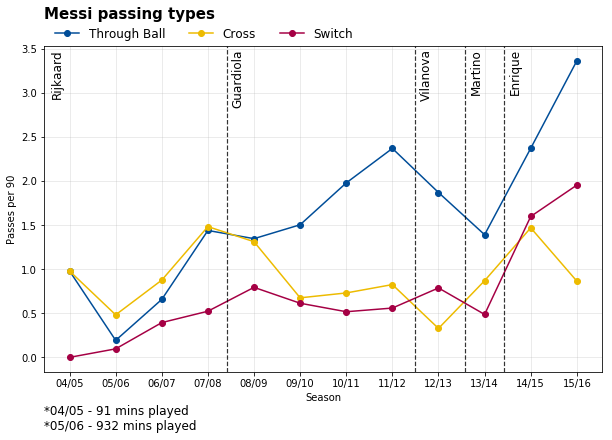

In [220]:
ind = np.flip(np.arange(len(years)))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,m_thru_p90,'-o',c='#004d98',label='Through Ball')
ax.plot(ind,m_cross_p90,'-o',c='#edbb00',label='Cross')
ax.plot(ind,m_switch_p90,'-o',c='#a50044',label='Switch')

for i in range(len(man_dates)-1):
    ax.axvline(man_dates[i+1],0,1,c='k',ls='--',lw=1.2,alpha=0.8)
    ax.text(man_dates[i+1]+0.1,3.5,man_names[i+1],fontsize=12,ha='left',va='top',rotation=90)
    
ax.text(man_dates[0]-0.4,3.5,man_names[0],fontsize=12,ha='left',va='top',rotation=90)
    
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Passes per 90')
ax.legend(loc=2,bbox_to_anchor=(0,1.09),ncol=3,frameon=False,fontsize=12)

ax.text(0.0,1.12,'Messi passing types',ha='left', va='top',transform=ax.transAxes,fontsize=15,fontweight='semibold')
ax.text(0.0, -0.1, '*04/05 - 91 mins played\n*05/06 - 932 mins played', ha='left', va='top', transform=ax.transAxes, fontsize=12)

ax.grid(True,alpha=0.3)

plt.show()
#fig.savefig('example_plots/messi_pass_type_p90.pdf',bbox_inches='tight')

In [185]:
m_pass_match = {}
for year in list(reversed(years)):
    m_pass_match[str(year)] = []
    for i in range(len(passes[str(year)])):
        m_pass_match[str(year)].append(passes[str(year)][i][(passes[str(year)][i]['player'] == messi)&
                                                     (passes[str(year)][i]['pass_type'] == 'Standard')])

In [186]:
m_pass_op_match = {}
for year in list(reversed(years)):
    m_pass_op_match[str(year)] = []
    for i in range(len(m_pass_match[str(year)])):
        m_pass_op_match[str(year)].append(len(m_pass_match[str(year)][i]))

In [212]:
m_pass_temp = [*m_pass_op_match.values()]
m_pass_all_df = pd.DataFrame([val for sublist in m_pass_temp for val in sublist])

In [214]:
roll_avg = m_pass_all_df.rolling(6).mean().values

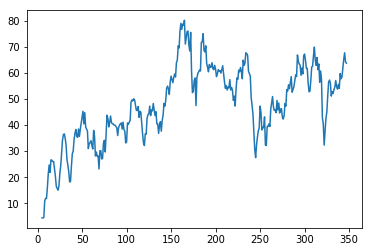

In [215]:
plt.plot(np.arange(len(roll_avg)),roll_avg)

## Carries and Dribbles

In [488]:
car_15 = get_carry(event_data_15)
m_car_15 = car_15[car_15['player'] == messi]

In [489]:
xg = 120
yg = 40
d = np.sqrt((120 - m_car_15['x']) ** 2 + (40 - m_car_15['y']) ** 2)
de = np.sqrt((120 - m_car_15['end_x']) ** 2 + (40 - m_car_15['end_y']) ** 2)
d.rename('dist', inplace=True)
de.rename('end_dist', inplace=True)

m_car_15 = pd.concat([m_car_15,d,de], axis=1)

m_car_prog_15 = m_car_15[(((m_car_15['dist'] - m_car_15['end_dist']) * 0.914) >= 5.0)
                         &(m_car_15['end_x'] >= 60)]

In [482]:
# car_15 = get_carry(event_data_15)
# m_car_15 = car_15[car_15['player'] == messi]
# m_car_prog_15 = m_car_15[((m_car_15['end_x'] - m_car_15['x']) * 0.914) >= 5.0]

In [490]:
event_df = clean_event_data(event_data_15)
passes = get_pass(event_data_15)
shots = get_shots(event_data_15)
df_index = []
car_outcome = []
pass_outcome = []
shot_outcome = []
drib_outcome = []
for index, row in m_car_prog_15.iterrows():
    #print('index = ',index)
    for j in row['related_events']:
        event = event_df[event_df['event_id'] == j]
        if event['m_index'].values > row['index']:
            if event['type'].values == 'Dribble':
                df_index.append(index)
                if event['outcome'].values == 'Complete':
                    car_outcome.append('Successful')
                    drib_outcome.append('Complete')
                else:
                    car_outcome.append('Unsuccessful')
                    drib_outcome.append('Incomplete')
                pass_outcome.append(None)
                shot_outcome.append(None)
                break
                    
            elif event['type'].values == 'Pass':
                df_index.append(index)
                if event['outcome'].values == 'Complete':
                    car_outcome.append('Successful')
                    pass_event = passes[passes['event_id'] == event['event_id'].values[0]]
                    if pass_event['shot_assist'].any() == True:
                        pass_outcome.append('Shot Assist')
                    elif pass_event['goal_assist'].any() == True:
                        pass_outcome.append('Goal Assist')
                    else:
                        pass_outcome.append('Complete')
                else:
                    car_outcome.append('Unsuccessful')
                    pass_outcome.append('Incomplete')
                shot_outcome.append(None)
                drib_outcome.append(None)
                break
                    
            elif event['type'].values == 'Shot':
                car_outcome.append('Successful')
                df_index.append(index)
                shot_event = shots[shots['event_id'] == event['event_id'].values[0]]
                shot_outcome.append(shot_event['outcome'].values[0])
                pass_outcome.append(None)
                drib_outcome.append(None)
                break
                
            elif event['type'].values == 'Dispossessed':
                car_outcome.append('Unsuccessful')
                df_index.append(index)
                shot_outcome.append(None)
                pass_outcome.append(None)
                drib_outcome.append(None)
                
            elif event['type'].values == 'Foul Won':
                if event['player'].values == messi:
                    car_outcome.append('Successful')
                    df_index.append(index)
                    shot_outcome.append(None)
                    pass_outcome.append(None)
                    drib_outcome.append(None)
                
            elif event['type'].values == 'Foul Committed':
                if event['player'].values == messi:
                    car_outcome.append('Unsuccessful')
                    df_index.append(index)
                    shot_outcome.append(None)
                    pass_outcome.append(None)
                    drib_outcome.append(None)
                
            elif event['type'].values == 'Miscontrol':
                car_outcome.append('Unsuccessful')
                df_index.append(index)
                shot_outcome.append(None)
                pass_outcome.append(None)
                drib_outcome.append(None)
                
            else:
                pass
                #car_outcome.append(event['type'].values)

carry_outcome = pd.DataFrame()
carry_outcome['index'] = df_index
carry_outcome['outcome'] = car_outcome
carry_outcome['pass_outcome'] = pass_outcome
carry_outcome['shot_outcome'] = shot_outcome
carry_outcome['dribble_outcome'] = drib_outcome

carry_outcome.set_index('index',inplace=True)
del carry_outcome.index.name

In [491]:
carry_outcome

,outcome,pass_outcome,shot_outcome,dribble_outcome
127,Unsuccessful,None,None,Incomplete
164,Unsuccessful,Incomplete,None,None
353,Successful,Shot Assist,None,None
379,Unsuccessful,Incomplete,None,None
514,Successful,Complete,None,None
...,...,...,...,...
27708,Successful,None,None,Complete
27709,Unsuccessful,Incomplete,None,None
27730,Successful,Complete,None,None
27750,Unsuccessful,Incomplete,None,None


In [492]:
m_car_prog_15 = pd.concat([m_car_prog_15,carry_outcome], axis=1)

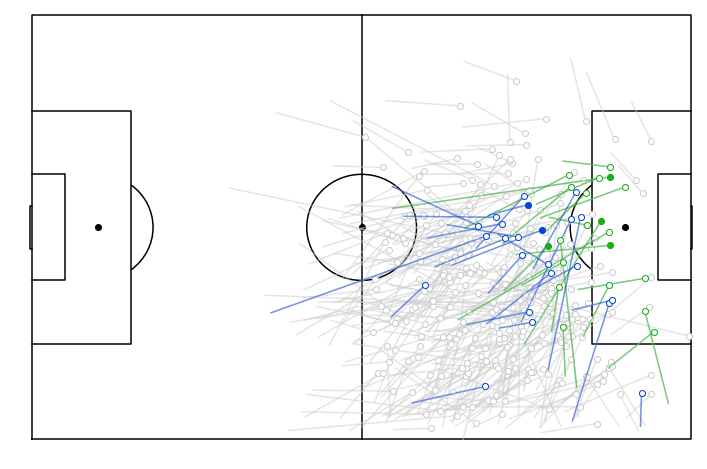

In [493]:
fig, ax = draw_pitch('w','k','h','f')

m_car_s = m_car_prog_15[m_car_prog_15['outcome'] == 'Successful']
m_car_u = m_car_prog_15[m_car_prog_15['outcome'] == 'Unsuccessful']
m_car_shot = m_car_prog_15[(m_car_prog_15['shot_outcome'] != 'Goal')&(m_car_prog_15['shot_outcome'].notnull())]
m_car_goal = m_car_prog_15[(m_car_prog_15['shot_outcome'] == 'Goal')]
m_car_pass = m_car_s[(m_car_s['pass_outcome'].notnull())]
m_car_sa = m_car_pass[(m_car_pass['pass_outcome'] == 'Shot Assist')]
m_car_ga = m_car_pass[(m_car_pass['pass_outcome'] == 'Goal Assist')]

xs = m_car_s['x'].values
ys = (80 - m_car_s['y'].values)
xse = m_car_s['end_x'].values
yse = (80 - m_car_s['end_y'].values)

xu = m_car_u['x'].values
yu = (80 - m_car_u['y'].values)
xue = m_car_u['end_x'].values
yue = (80 - m_car_u['end_y'].values)

xsh = m_car_shot['x'].values
ysh = (80 - m_car_shot['y'].values)
xshe = m_car_shot['end_x'].values
yshe = (80 - m_car_shot['end_y'].values)

xg = m_car_goal['x'].values
yg = (80 - m_car_goal['y'].values)
xge = m_car_goal['end_x'].values
yge = (80 - m_car_goal['end_y'].values)

xsa = m_car_sa['x'].values
ysa = (80 - m_car_sa['y'].values)
xsae = m_car_sa['end_x'].values
ysae = (80 - m_car_sa['end_y'].values)

xga = m_car_ga['x'].values
yga = (80 - m_car_ga['y'].values)
xgae = m_car_ga['end_x'].values
ygae = (80 - m_car_ga['end_y'].values)



zo=10
ax.plot([xs,xse],[ys,yse],'0.8',alpha=0.5,zorder=zo)
ax.scatter(xse,yse,facecolor='w',edgecolor='0.8',zorder=zo+1)
ax.plot([xsh,xshe],[ysh,yshe],'xkcd:green',alpha=0.5,zorder=zo+2)
ax.scatter(xshe,yshe,facecolor='w',edgecolor='xkcd:green',zorder=zo+3)
ax.plot([xg,xge],[yg,yge],'xkcd:green',alpha=0.5,zorder=zo+2)
ax.scatter(xge,yge,facecolor='xkcd:green',edgecolor='xkcd:green',zorder=zo+3)
ax.plot([xsa,xsae],[ysa,ysae],'xkcd:blue',alpha=0.5,zorder=zo+2)
ax.scatter(xsae,ysae,facecolor='w',edgecolor='xkcd:blue',zorder=zo+3)
ax.plot([xga,xgae],[yga,ygae],'xkcd:blue',alpha=0.5,zorder=zo+2)
ax.scatter(xgae,ygae,facecolor='xkcd:blue',edgecolor='xkcd:blue',zorder=zo+3)
#ax.plot([xu,xue],[yu,yue],'0.5',alpha=0.5)

plt.show()

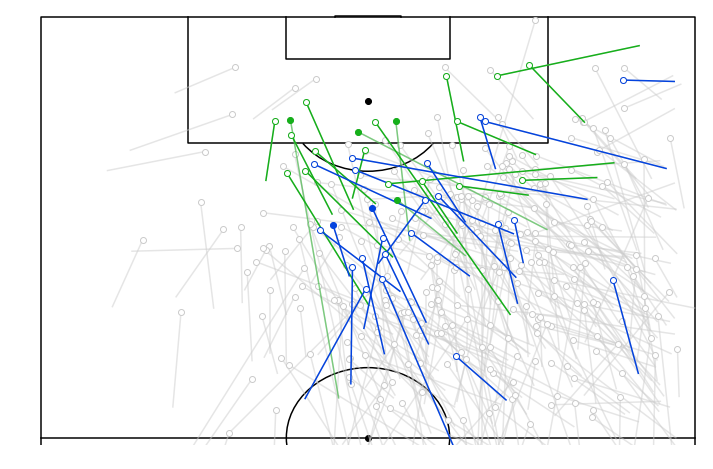

In [494]:
fig, ax = draw_pitch('w','k','v','h')

m_car_s = m_car_prog_15[m_car_prog_15['outcome'] == 'Successful']
m_car_u = m_car_prog_15[m_car_prog_15['outcome'] == 'Unsuccessful']
m_car_shot = m_car_prog_15[(m_car_prog_15['shot_outcome'] != 'Goal')&(m_car_prog_15['shot_outcome'].notnull())]
m_car_goal = m_car_prog_15[(m_car_prog_15['shot_outcome'] == 'Goal')]
m_car_pass = m_car_s[(m_car_s['pass_outcome'].notnull())]
m_car_sa = m_car_pass[(m_car_pass['pass_outcome'] == 'Shot Assist')]
m_car_ga = m_car_pass[(m_car_pass['pass_outcome'] == 'Goal Assist')]
m_car_drib = m_car_s[(m_car_s['dribble_outcome'].notnull())]

xs = m_car_s['x'].values
ys = m_car_s['y'].values
xse = m_car_s['end_x'].values
yse = m_car_s['end_y'].values

xsh = m_car_shot['x'].values
ysh = m_car_shot['y'].values
xshe = m_car_shot['end_x'].values
yshe = m_car_shot['end_y'].values

xg = m_car_goal['x'].values
yg = m_car_goal['y'].values
xge = m_car_goal['end_x'].values
yge = m_car_goal['end_y'].values

xsa = m_car_sa['x'].values
ysa = m_car_sa['y'].values
xsae = m_car_sa['end_x'].values
ysae = m_car_sa['end_y'].values

xga = m_car_ga['x'].values
yga = m_car_ga['y'].values
xgae = m_car_ga['end_x'].values
ygae = m_car_ga['end_y'].values

xd = m_car_drib['x'].values
yd = m_car_drib['y'].values
xde = m_car_drib['end_x'].values
yde = m_car_drib['end_y'].values



zo=100
ax.plot([ys,yse],[xs,xse],'0.8',alpha=0.5,zorder=zo)
ax.scatter(yse,xse,facecolor='w',edgecolor='0.8',zorder=zo+1)
ax.plot([ysh,yshe],[xsh,xshe],'xkcd:green',alpha=1,zorder=zo+2)
ax.scatter(yshe,xshe,facecolor='w',edgecolor='xkcd:green',zorder=zo+3)
ax.plot([yg,yge],[xg,xge],'xkcd:green',alpha=0.5,zorder=zo+2)
ax.scatter(yge,xge,facecolor='xkcd:green',edgecolor='xkcd:green',zorder=zo+3)
ax.plot([ysa,ysae],[xsa,xsae],'xkcd:blue',alpha=1,zorder=zo+2)
ax.scatter(ysae,xsae,facecolor='w',edgecolor='xkcd:blue',zorder=zo+3)
ax.plot([yga,ygae],[xga,xgae],'xkcd:blue',alpha=1,zorder=zo+2)
ax.scatter(ygae,xgae,facecolor='xkcd:blue',edgecolor='xkcd:blue',zorder=zo+3)
#ax.plot([yd,yde],[xd,xde],'xkcd:red',alpha=0.5,zorder=zo+2)
#ax.scatter(yde,xde,facecolor='w',edgecolor='xkcd:red',zorder=zo+3)

plt.show()

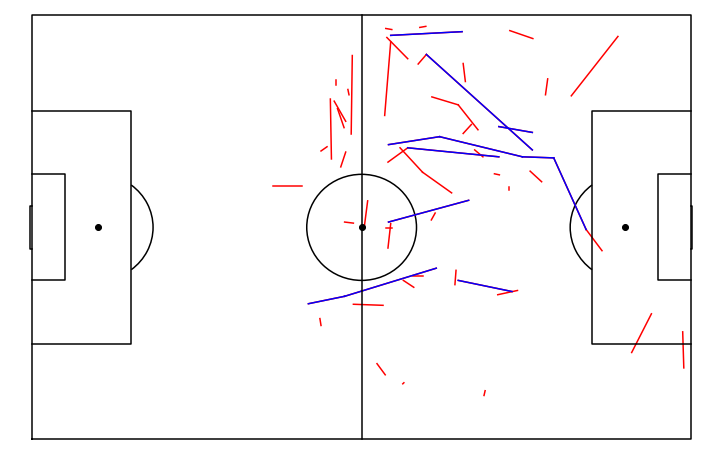

In [271]:
fig, ax = draw_pitch('w','k','h','f')

x = m_car['x'].values
y = m_car['y'].values
xe = m_car['end_x'].values
ye = m_car['end_y'].values

xp = m_car_prog['x'].values
yp = m_car_prog['y'].values
xep = m_car_prog['end_x'].values
yep = m_car_prog['end_y'].values

ax.plot([x,xe],[y,ye],'r')
ax.plot([xp,xep],[yp,yep],'b')
plt.show()